In [15]:
import pandas as pd
import os
import numpy as np
from datetime import datetime

In [68]:
orders = pd.read_csv('orders_formatted/order_details.csv', sep=';')
df_orders = pd.read_csv('orders_formatted/orders.csv', sep=';')
df_ingredients = pd.read_csv('data/pizza_types.csv',encoding = "ISO-8859-1")
df_pizzas = pd.read_csv('data/pizzas.csv')

In [69]:
# dtypes of each dataset

types = {'object': 'str', 'int64': 'int', 'float64': 'float', 'datetime64[ns]': 'datetime'}
print('Data types of each dataset:')
df_list = [orders, df_orders, df_ingredients, df_pizzas]
df_names = ['orders', 'df_orders', 'df_ingredients', 'df_pizzas']
for dataset in range(len(df_list)):
    print(df_names[dataset].upper() + ':',df_list[dataset].dtypes.apply(lambda x: types[x.name]).to_dict())

Data types of each dataset:
ORDERS: {'order_details_id': 'int', 'order_id': 'int', 'pizza_id': 'str', 'quantity': 'str'}
DF_ORDERS: {'order_id': 'int', 'date': 'str', 'time': 'str'}
DF_INGREDIENTS: {'pizza_type_id': 'str', 'name': 'str', 'category': 'str', 'ingredients': 'str'}
DF_PIZZAS: {'pizza_id': 'str', 'pizza_type_id': 'str', 'size': 'str', 'price': 'float'}


In [70]:
#date to datetime
for date in range(len(df_orders['date'])):
    
    try:
        df_orders['date'][date] = pd.to_datetime(df_orders['date'][date]).date()
    except:
        df_orders['date'][date] = datetime.fromtimestamp(float(df_orders['date'][date])).date()



/var/folders/y8/t4864jg93dsgpnkkldf_6yl00000gn/T/ipykernel_10435/980972783.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_orders['date'][date] = pd.to_datetime(df_orders['date'][date]).date()
/var/folders/y8/t4864jg93dsgpnkkldf_6yl00000gn/T/ipykernel_10435/980972783.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_orders['date'][date] = datetime.fromtimestamp(float(df_orders['date'][date])).date()


In [77]:
# data quality check
print('Data quality check:')
print('Number of nulls in orders:',orders.isnull().sum().sum())
print('Number of nulls in df_orders:',df_orders.isnull().sum().sum())
print('Number of nulls per column in...')
datas = {'orders': orders, 'df_orders': df_orders}
for ds_name, ds in datas.items():
    print(ds_name.upper() + ':')
    for column in ds.columns:
        print(column,':',ds[column].isnull().sum())


Data quality check:
Number of nulls in orders: 10399
Number of nulls in df_orders: 4391
Number of nulls per column in...
ORDERS:
order_details_id : 0
order_id : 0
pizza_id : 5673
quantity : 4726
DF_ORDERS:
order_id : 0
date : 2353
time : 2038


In [79]:

df_orders = df_orders[df_orders['date'].isnull() == False]
df_orders.sort_values(by=['date','order_id'], inplace=True)
df_orders.head()


,order_id,date,time
7970,1,2016-01-01,11H 38M 36S
12320,2,2016-01-01,00:00 AM
10652,4,2016-01-01,12:16:31
4537,5,2016-01-01,00:00 AM
4454,6,2016-01-01,12:29:36


In [7]:
# Getting the sizes of each pizza
pizza_id = []
pizza_type = []
for pizza in list(orders['pizza_id']):
    temp = pizza.split('_')
    pizza_type.append(temp[-1].upper())
    temp.remove(temp[-1])
    pizza_id.append('_'.join(temp))
orders['pizza_id'] = pizza_id
orders['pizza_size'] = pizza_type

In [8]:
# Merging datasets
orders = orders.groupby('order_id').agg(list)
orders = orders.drop(columns=['order_details_id'])
orders = orders.merge(df_orders, on='order_id')
orders = orders.drop(columns=['order_id'])

In [9]:
pizza_orders = orders[['pizza_id','quantity', 'pizza_size','date']]
pizza_orders = pizza_orders.groupby('date').sum().sort_values(by='date')

# Grouping pizzas by type

# Getting the ingredients for each pizza size
ingredients = []
sizes= {'S':1, 'M':1.5, 'L':2, 'XL':2.5, 'XXL':3}

for day in range(len(pizza_orders['pizza_id'])):
    pizza_list = pizza_orders['pizza_id'][day]
    temp1 = []
    temp2 = []
    temp3 = []

    for i in range(len(pizza_list)):
        if pizza_list[i] not in temp1 or (pizza_list[i] in temp1 and temp3[temp1.index(pizza_list[i])]) != pizza_orders['pizza_size'][day][i]:
            temp1.append(pizza_list[i])
            temp2.append(pizza_orders['quantity'][day][i])
            temp3.append(pizza_orders['pizza_size'][day][i])
        else:
            temp2[temp1.index(pizza_list[i])] += pizza_orders['quantity'][day][i]
    
    # Getting the ingredients for each day
    day_ingredients = {}
    for pizza in range(len(pizza_list)):
        t = list(df_ingredients[df_ingredients['pizza_type_id'] == pizza_list[pizza]]['ingredients'])[0]
        for i in t.split(', '):
            if i in day_ingredients:
                day_ingredients[i] += sizes[pizza_orders['pizza_size'][day][pizza]]*temp2[temp1.index(pizza_list[pizza])]
            else:
                day_ingredients[i] = sizes[pizza_orders['pizza_size'][day][pizza]]*temp2[temp1.index(pizza_list[pizza])]
        for key,value in day_ingredients.items():
            day_ingredients[key] = int(round(value, 0))
    ingredients.append(day_ingredients)
   

    pizza_orders['pizza_id'][day] = temp1
    pizza_orders['quantity'][day] = temp2
    pizza_orders['pizza_size'][day] = temp3
    

pizza_orders['ingredients'] = ingredients
pizza_orders.head()



,pizza_id,quantity,pizza_size,ingredients
date,,,,
2015-01-01,"[hawaiian, classic_dlx, five_cheese, ital_supr...","[1, 7, 7, 6, 2, 6, 1, 2, 1, 1, 1, 4, 2, 1, 5, ...","[M, M, L, L, M, L, M, L, M, M, S, S, S, S, S, ...","{'Sliced Ham': 6, 'Pineapple': 96, 'Mozzarella..."
2015-01-02,"[ital_veggie, soppressata, thai_ckn, spinach_f...","[2, 4, 4, 2, 1, 6, 3, 1, 3, 1, 1, 4, 8, 5, 1, ...","[S, L, L, L, S, L, L, S, L, S, L, L, S, L, L, ...","{'Eggplant': 11, 'Artichokes': 173, 'Tomatoes'..."
2015-01-03,"[mediterraneo, pepperoni, spicy_ital, cali_ckn...","[1, 2, 3, 4, 5, 2, 5, 4, 4, 4, 3, 1, 1, 1, 4, ...","[L, S, M, M, L, L, M, L, S, M, M, M, S, S, L, ...","{'Spinach': 152, 'Artichokes': 48, 'Kalamata O..."
2015-01-04,"[cali_ckn, ital_veggie, pep_msh_pep, the_greek...","[3, 1, 1, 2, 5, 1, 4, 2, 3, 2, 6, 1, 1, 1, 3, ...","[L, M, L, S, L, S, M, S, M, S, L, S, M, M, S, ...","{'Chicken': 82, 'Artichoke': 26, 'Spinach': 66..."
2015-01-05,"[five_cheese, green_garden, hawaiian, spinach_...","[6, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 3, 1, 1, ...","[L, M, L, M, L, L, L, M, L, L, S, M, L, M, M, ...","{'Mozzarella Cheese': 129, 'Provolone Cheese':..."


In [10]:
# Getting the week number of each day
week = []
for i in range(len(pizza_orders)):
    doy = pizza_orders.iloc[i].name.timetuple().tm_yday
    w = (doy) // 7
    week.append(w)
pizza_orders['week'] = week
pizza_orders.insert(0, 'week', pizza_orders.pop('week'))
pizza_orders.to_csv('pizza_orders.csv')
pizza_orders.head()


,week,pizza_id,quantity,pizza_size,ingredients
date,,,,,
2015-01-01,0,"[hawaiian, classic_dlx, five_cheese, ital_supr...","[1, 7, 7, 6, 2, 6, 1, 2, 1, 1, 1, 4, 2, 1, 5, ...","[M, M, L, L, M, L, M, L, M, M, S, S, S, S, S, ...","{'Sliced Ham': 6, 'Pineapple': 96, 'Mozzarella..."
2015-01-02,0,"[ital_veggie, soppressata, thai_ckn, spinach_f...","[2, 4, 4, 2, 1, 6, 3, 1, 3, 1, 1, 4, 8, 5, 1, ...","[S, L, L, L, S, L, L, S, L, S, L, L, S, L, L, ...","{'Eggplant': 11, 'Artichokes': 173, 'Tomatoes'..."
2015-01-03,0,"[mediterraneo, pepperoni, spicy_ital, cali_ckn...","[1, 2, 3, 4, 5, 2, 5, 4, 4, 4, 3, 1, 1, 1, 4, ...","[L, S, M, M, L, L, M, L, S, M, M, M, S, S, L, ...","{'Spinach': 152, 'Artichokes': 48, 'Kalamata O..."
2015-01-04,0,"[cali_ckn, ital_veggie, pep_msh_pep, the_greek...","[3, 1, 1, 2, 5, 1, 4, 2, 3, 2, 6, 1, 1, 1, 3, ...","[L, M, L, S, L, S, M, S, M, S, L, S, M, M, S, ...","{'Chicken': 82, 'Artichoke': 26, 'Spinach': 66..."
2015-01-05,0,"[five_cheese, green_garden, hawaiian, spinach_...","[6, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 3, 1, 1, ...","[L, M, L, M, L, L, L, M, L, L, S, M, L, M, M, ...","{'Mozzarella Cheese': 129, 'Provolone Cheese':..."


In [11]:
# We take all the ingredients and put them in a list
total_ingredients = []
for i in df_ingredients['ingredients']:
    total_ingredients += i.split(', ')
total_ingredients = list(set(total_ingredients))

In [12]:
# Creating a list of dictionaries with the ingredients and their quantities per week
ingredients_w = []
for week in range(53):
    ingredients_w.append({})
    for day in pizza_orders[pizza_orders['week']==week].iterrows():   

        for key, value in day[1]['ingredients'].items():
            if key in ingredients_w[week]:
                ingredients_w[week][key] += value
            else:
                ingredients_w[week][key] = value


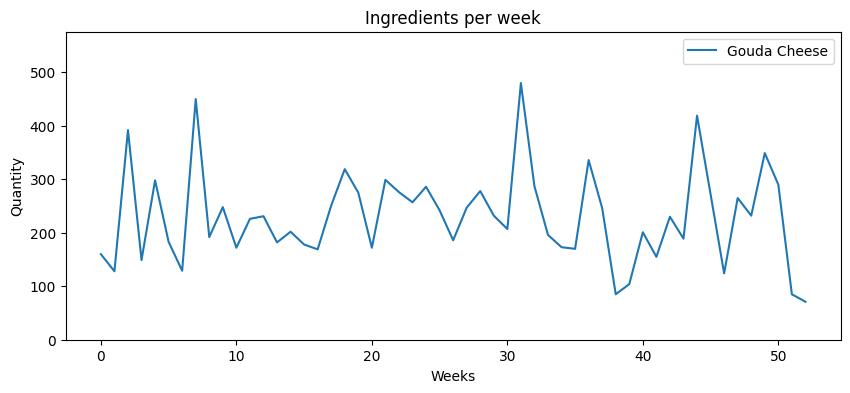

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import random

# graph of ingredients per week
plt.figure(figsize=(10,4))
plt.title('Ingredients per week')
plt.xlabel('Weeks')
plt.ylabel('Quantity')
ing = total_ingredients[random.randint(0, len(total_ingredients)-1)]

x = np.array(range(53))
y = np.array([ingredients_w[i][ing] for i in range(53)])
plt.ylim(0,y.max()*1.2)
plt.plot(x, y, label=ing)
plt.legend()
plt.show()

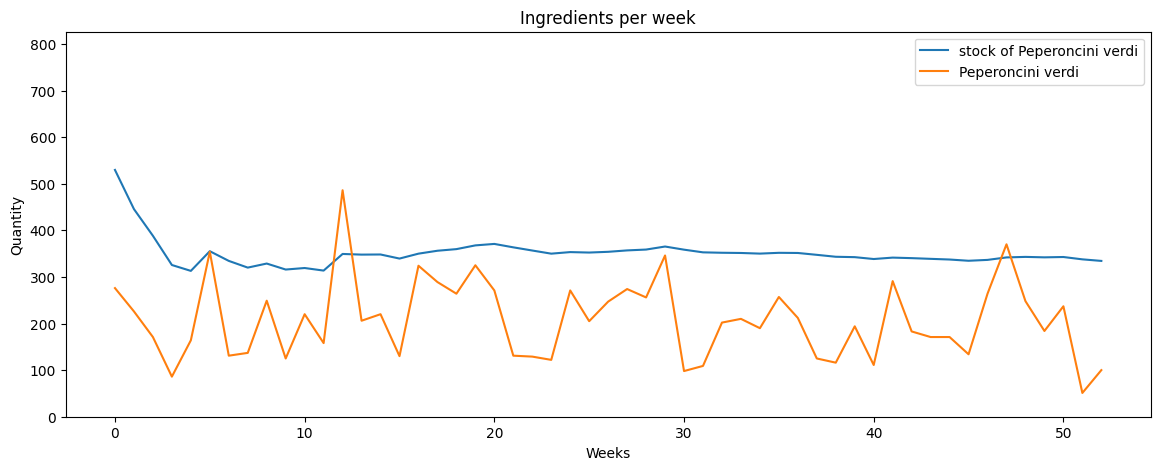

,week,Pears,Thai Sweet Chilli Sauce,Mozzarella Cheese,Thyme,Genoa Salami,Pineapple,Friggitello Peppers,Bacon,Goat Cheese,...,Plum Tomatoes,Cilantro,Jalapeno Peppers,Barbecued Chicken,Asiago Cheese,Onions,Chorizo Sausage,Italian Sausage,Prosciutto di San Daniele,Soppressata Salami
0,0,29,930,3208,29,222,1638,32,1402,1302,...,137,730,1185,657,709,434,557,557,256,117
1,1,7,101,981,7,141,135,116,148,159,...,27,309,388,128,154,252,121,121,119,44
2,2,11,235,1635,11,93,391,36,288,155,...,48,463,980,152,193,231,127,127,57,67
3,3,28,339,1289,28,128,557,55,313,167,...,34,225,338,241,185,108,209,209,156,31
4,4,23,261,1151,23,120,448,160,657,356,...,4,143,470,639,324,155,299,299,96,82


In [14]:
#Initialize the stock for each ingredient

stock = {}
for i in total_ingredients:
    stock[i] = [0,0]

# For plotting a random ingredient
x_axis = np.array(range(53))
stock_ing = []
ing = random.randint(0, len(total_ingredients)-1)

weekly_ing = pd.DataFrame()
weekly_ing['week'] = range(53)
for i in total_ingredients:
    weekly_ing[i] = [0 for _ in range(53)]

# An example of how we would predict for more data
for week in range(53):
    count = 0
    for i in range(len(total_ingredients)):
        # We update the average of all the weeks before 
        stock[total_ingredients[i]][1] = stock[total_ingredients[i]][1]*week + ingredients_w[week][total_ingredients[i]]
        stock[total_ingredients[i]][1] = stock[total_ingredients[i]][1]/(week+1)
        if week == 0:
            stock[total_ingredients[i]][1] = int(ingredients_w[week][total_ingredients[i]]*1.2)

        # The week passes and ingredients are taken
        stock[total_ingredients[i]][0] -= ingredients_w[week][total_ingredients[i]]

        # The stock is updated to 1.6 times the average
        p = 1.6 - stock[total_ingredients[i]][0]/stock[total_ingredients[i]][1]
        stock[total_ingredients[i]][0] += stock[total_ingredients[i]][1]*p
        
        # For graphing
        weekly_ing[total_ingredients[i]][week] = round(stock[total_ingredients[i]][1]*p)
        if i == ing:
            stock_ing.append(stock[total_ingredients[ing]][0])

# Graph of stock of one random ingredient
plt.figure(figsize=(14,5))
plt.title('Ingredients per week')
plt.xlabel('Weeks')
plt.ylabel('Quantity')
ing = total_ingredients[ing]
y = np.array([ingredients_w[i][ing] for i in range(53)])
plt.ylim(0, y.max()*1.7)
plt.plot(x_axis, stock_ing, label=f'stock of {ing}')
plt.plot(x, y, label=ing)

plt.legend()
plt.show()
weekly_ing.to_csv('data/weekly_ing.csv')